## Total variation image decomposition and denoising
Notebook related to the paper *Total variation based image decomposition and denoising for microscopy images*, with step-by-step comments. More details can be found in the paper itself and the general AiSurf's README file.

There are different functionalities, that can be commented or uncommented when needed.

In [101]:
import denoising_tools
import skimage
import numpy as np
import matplotlib.pyplot as plt
import configparser
import os
import datetime
from skimage import filters

In [ ]:
file = open('param_dn.ini', 'r')
conf = configparser.ConfigParser()
conf.read_file(file)

path = conf.get('files', 'path', raw=True)
filename = conf.get('files', 'filename', raw=True)
extension = conf.get('files', 'extension')
iterations = conf.getint('parameters', 'iterations', fallback = 2000)
nabla_comp = conf.get('parameters', 'nabla_comp', fallback='both')      # both, x, y
algo = conf.getint('parameters', 'algo', fallback=2)                    # 1: l1-TV, 2: Huber-ROF, 3: l1-TGV
lam = conf.getfloat('parameters', 'lam', fallback=0.01)
alpha = conf.getfloat('parameters', 'alpha', fallback=0.05)             # Only for Huber-ROF
gif_yn = conf.getboolean('parameters', 'gif_yn', fallback=False)
alpha1 = conf.getfloat('parameters', 'alpha1', fallback=1)              # TGV: weight of 1st order term, no need to change it
alpha2 = conf.getfloat('parameters', 'alpha2', fallback=2)              # TGV: weight of 2nd order term, no need to change it
err = conf.getfloat('parameters', 'err', fallback=5E-6)                 # RMSE

file.close()

with open('param_dn.ini', 'r') as reader:
    print('Input text file:\n')
    print(reader.read())

if algo ==1:
    tau = 0.01
    save_path = 'results/l1_TV/'
    method = 'l1TV' # needed for naming the files
if algo == 2:
    tau = 0.01 # never needed to change this, taken from the paper
    save_path = 'results/huber-ROF/'
    method = 'hROF'
if algo == 3:
    tau = 0.01
    save_path = 'results/l1_TGV/'
    method = 'l1TGV'

Input text file:

[files]
path = input_img/
filename = Sr_KTO_0594
extension = .png

[parameters]
iterations = 10000
err = 5E-6
nabla_comp = both
algo = 2
lam = 0.5
alpha = 0.5
gif_yn = False



Load the image(s), upscale if needed.

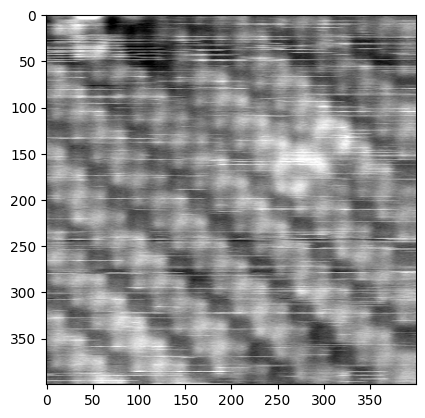

In [103]:
img = skimage.io.imread(path+filename+extension, as_gray=True)
img = img/np.max(img)
plt.figure()
plt.imshow(img, cmap='gray')
plt.show()

In [104]:
# # UPSCALING

# import cv2 as cv
# scale_factor = 1.5
# img = cv.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_CUBIC)

# *algo* 1: l1-TV, 2: hROF, 3: l1-TGV

In [105]:
if algo == 1 or algo == 2:
    img_bg, ii = denoising_tools.l1TV_ROF(img, iterations, nabla_comp, algo, lam, tau, alpha, err,
                                        gif=gif_yn)
    M, N = img.shape
    img_bg = img_bg.reshape(M, N)
    
elif algo == 3:
    img_bg, ii = denoising_tools.l1TGV(img, iterations, nabla_comp, lam, tau, alpha1, alpha2, err,
                                     gif=gif_yn)
    M, N = img.shape
    img_bg = img_bg[:M*N].reshape(M, N)

iter: 0
Iteration: 100,  RMSE: 9.682254726353453e-05
Iteration: 200,  RMSE: 3.3939692178286125e-05
Iteration: 300,  RMSE: 1.5974884502505015e-05
Iteration: 400,  RMSE: 8.080291849783326e-06
Iteration: 500,  RMSE: 4.211487746777001e-06
Total # iterations: 500
Execution time: 3.5 s.


In [106]:
if nabla_comp == 'x':
    save_path_full = save_path + filename + '/x/' + 'RMSE_' + str(err) + '/'
elif nabla_comp == 'y':
    save_path_full = save_path + filename + '/y/' + 'RMSE_' + str(err) + '/'
elif nabla_comp == 'both':
    save_path_full = save_path + filename + '/full/' + 'RMSE_' + str(err) + '/'

if algo == 1:
    in_string = method + '_nabla-'+str(nabla_comp) + '_it'+str(ii)+ '_lam'+str(lam)
if algo == 2:
    in_string = method + '_nabla-'+str(nabla_comp) + '_it'+str(ii)+ '_lam'+str(lam) + '_alpha'+str(alpha)
if algo == 3:
    in_string = method + '_nabla-'+str(nabla_comp) + '_it'+str(ii)+ '_lam'+str(lam) + '_a1-'+str(alpha1) + '_a2-'+str(alpha2)
# date = datetime.datetime.now()
# date = date.strftime('%d%b%Y_%H:%M')

try: 
    os.makedirs(save_path_full)
except OSError as error: # prints error instead of blocking the calculation
    print(error)

[Errno 17] File exists: 'results/huber-ROF/Sr_KTO_0594/full/RMSE_5e-06/'


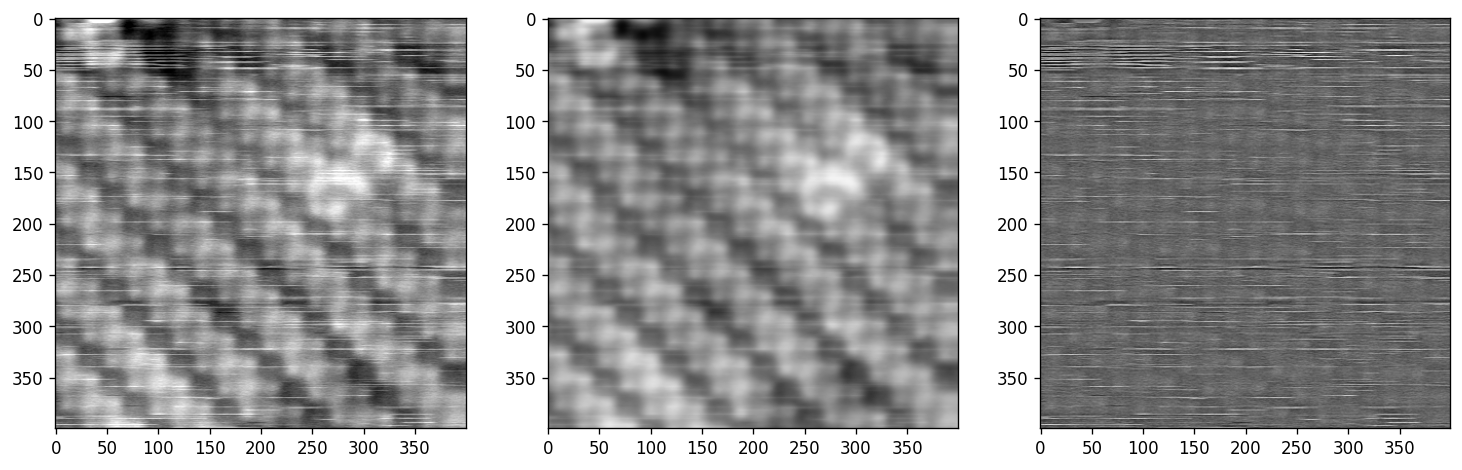

In [107]:
figure, axis = plt.subplots(1, 3, figsize=(15, 5), dpi=120)    
axis[0].imshow(img, cmap="gray", vmin=0, vmax=1)
axis[1].imshow(img_bg, cmap="gray", vmin=0, vmax=1) # , vmin=0, vmax=1 for _bg and _reconstr
axis[2].imshow((img-img_bg), cmap="gray")

median_kernel = (3, 1)
final_img = filters.median(img-img_bg, footprint=np.ones(median_kernel)) # filter along y-direction

# Save figures in the same directory:
plt.imsave(save_path_full+filename+'_bg_'+in_string+'.png', img_bg, cmap="gray", vmin=0, vmax=1) # , vmin=0, vmax=1 for _bg and _reconstr
plt.imsave(save_path_full+filename+'_clean_'+in_string+'.png', (img-img_bg), cmap="gray")
plt.imsave(save_path_full+filename+'_'+in_string+'_median'+'.png', final_img, cmap="gray")

### Second, optional step (terraces, smoothing, etc.)

Optional second step, quick setup. Change the input variable and the image (de)composition as better fit to the task. <br>
Used for additional image decomposition or recomposition. It works only for a single image, but can be extended to work with more at once.

Uncomment the next two cells to use.

In [108]:


# nabla_comp = 'both'
# lam = 1.5
# iterations = 3000

# # img_bg2, ii = denoising_tools.l1TV_ROF(final_img, iterations, nabla_comp, algo, lam, tau, alpha, err,
# #                                     gif=gif_yn)
# img_bg2, ii = denoising_tools.l1TGV(final_img, iterations, nabla_comp, lam, tau, alpha1, alpha2, err,
#                                     gif=gif_yn) # TGV
# M, N = img.shape
# # img_bg2 = img_bg2.reshape(M, N) # for Huber-ROF and TV-L1
# img_bg2 = img_bg2[:M*N].reshape(M, N) # for TGV

In [109]:
# figure, axis = plt.subplots(1, 3, figsize=(15, 5), dpi=120)    
# axis[0].imshow(img, cmap="gray", vmin=0, vmax=1)
# axis[1].imshow(img_bg2, cmap="gray") # , vmin=0, vmax=1 for _bg and _reconstr
# axis[2].imshow(img-img_bg-final_img+img_bg2, cmap="gray")

# # Save the image made of the desired composition
# plt.imsave(save_path_full+filename+'_smooth_'+in_string+'.png', img_bg2, cmap="gray")
# plt.imsave(save_path_full+filename+'_reconstr_'+in_string+'.png', img-img_bg-final_img+img_bg2, cmap="gray")

## For multiple images at once
Originally made for the STEM images showed in the Supplementary material of the paper.

In [110]:
# img = np.load(path+filename+extension)
# print(np.shape(img))
# plt.imshow(img[0][0], cmap='gray')
# print(np.min(img[0][0]))
# print(np.max(img[0][0]))
  
# img_bg_tot = [[] for x in range(len(img))]

In [ ]:
# # RESCALE
# import cv2 as cv
# scale_factor = 2.3


# # Save all the images inside a folder named after the exact date the calculations started
# date = datetime.datetime.now()
# date = date.strftime('%d%b%Y_%H:%M')
# print('Date:{}'.format(date))

# if nabla_comp == 'x':
#     save_path_full = save_path + filename + '/x/' + 'RMSE_' + str(err) + '/' + str(date) + '/'
# elif nabla_comp == 'y':
#     save_path_full = save_path + filename + '/y/' + 'RMSE_' + str(err) + '/' + str(date) + '/'
# elif nabla_comp == 'both':
#     save_path_full = save_path + filename + '/full/' + 'RMSE_' + str(err) + '/' + str(date) + '/'

# try:
#     os.makedirs(save_path_full)
# except OSError as error: # prints error instead of blocking the calculation
#     print(error)


# # Create informative .txt files
# # Saves a copy of the parameters file, in the given directory
# with open(save_path_full+'param_dn.ini', 'w') as writer:
#     with open('param_dn.ini', 'r') as reader:
#         writer.write(reader.read())

# # (not working yet) Save iterations, timing and RMSE in a file. Useful to look when there are convergence problems
# # sys.stdout = open(save_path_full+"iterations.txt", "w")


# for i in range(2, len(img)):
#     for j in range(len(img[0])):
        
#         # Norm:
#         img[i][j] /= np.max(img[i][j])
#         img_ = cv.resize(img[i][j], None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_CUBIC)

#         print('Denoising img{}{}'.format(i,j))
#         if algo == 1 or algo == 2:
#             img_bg, ii = denoising_tools.l1TV_ROF(img_, iterations, nabla_comp, algo, lam_lst[i], tau, alpha, err,
#                                                 gif=gif_yn)
#             M, N = img_.shape
#             img_bg = img_bg.reshape(M, N)
#             img_bg_tot[i].append(img_bg)
            
#         elif algo == 3:
#             img_bg, ii = denoising_tools.l1TGV(img_, iterations, nabla_comp, lam_lst[i], tau, alpha1, alpha2, err,
#                                             gif=gif_yn)
#             M, N = img_.shape
#             img_bg = img_bg[:M*N].reshape(M, N)
#             img_bg_tot[i].append(img_bg)

#         in_string = method + '_' + str(i) + str(j) # + '_lam_' + str(lam_lst[i])

#         median_kernel = (3, 1)
#         final_img = filters.median(img_-img_bg, footprint=np.ones(median_kernel)) # filter along y-direction

#         # Save figures in the same directory:
#         plt.imsave(save_path_full+filename+'_bg_'+in_string+'.png', img_bg, cmap="gray") # , vmin=0, vmax=1 for _clean as clean image
#         plt.imsave(save_path_full+filename+'_clean_'+in_string+'.png', img_-img_bg, cmap="gray")
#         # plt.imsave(save_path_full+filename+'_'+in_string+'_median'+'.png', final_img, cmap="gray")



In [112]:
# Save the outputs like in the Supplementary materials of the paper.

# fig1, ax = plt.subplots(len(img), len(img[0]), figsize=(3*len(img), 3*len(img[0])), dpi=120)
# for i in range(len(img)):
#     for j in range(len(img[0])):
#         ax[i, j].imshow(img_bg_tot[i][j], cmap="gray")
#         ax[i, j].axis('off')
# plt.subplots_adjust(left=0.05, bottom=0.05, right=0.5, top=0.85, wspace=0.05, hspace=0.05)
# fig1.show()

# fig2, ax = plt.subplots(len(img), len(img[0]), figsize=(3*len(img), 3*len(img[0])), dpi=120)
# for i in range(len(img)):
#     for j in range(len(img[0])):
#         ax[i, j].imshow(img[i][j], cmap="gray")
#         ax[i, j].axis('off')
# plt.subplots_adjust(left=0.05, bottom=0.05, right=0.5, top=0.85, wspace=0.05, hspace=0.05)
# fig2.show()

# # fig3, ax = plt.subplots(len(img), len(img[0]), figsize=(3*len(img), 3*len(img[0])), dpi=120)
# # for i in range(len(img)):
# #     for j in range(len(img[0])):
# #         ax[i, j].imshow(img[i][j]- img_bg_tot[i][j], cmap="gray")
# #         ax[i, j].axis('off')
# # plt.subplots_adjust(left=0.05, bottom=0.05, right=0.5, top=0.85, wspace=0.05, hspace=0.05)
# # fig3.show()

# fig1.savefig(save_path_full+'output_bg.png', bbox_inches='tight')
# fig2.savefig(save_path_full+'input.png', bbox_inches='tight')
# # fig3.savefig(save_path_full+'output_diff.png', bbox_inches='tight')

In [113]:
### OLD!
# Saves a copy of the parameters file, in the given directory
# with open(save_path_full+'param_'+date+'.ini', 'w') as writer:
#     with open('param_dn.ini', 'r') as reader:
#         writer.write(reader.read())

## For multiple input values <br>
I haven't extended it to TGV yet.
Note that depending on the parameter that gets changed, the lines with \#\#\#\# at the end have to be modified (i.e. put PARAM in the relevant position).

In [114]:
# param_list = [0.01, 0.5, 1, 5]

# M, N = img.shape
# if nabla_comp == 'x':
#     save_path_full = save_path + filename + '/x/' + 'RMSE_' + str(err) + '/'
# elif nabla_comp == 'y':
#     save_path_full = save_path + filename + '/y/' + 'RMSE_' + str(err) + '/'
# elif nabla_comp == 'both':
#     save_path_full = save_path + filename + '/full/' + 'RMSE_' + str(err) + '/'
    
# try: 
#     os.makedirs(save_path_full)
# except OSError as error: # prints error instead of blocking the calculations
#     print(error)

# for PARAM in param_list:
#     print('--- Chosen param. = {} ---'.format(PARAM))
#     img_bg, ii = denoising_tools.l1TV_ROF(img, iterations, nabla_comp, algo, PARAM, tau, alpha, err, ####
#                                         gif=gif_yn)
#     img_bg = img_bg.reshape(M, N)

#     if algo==1:
#         in_string = method + '_nabla-'+str(nabla_comp) + '_it'+str(ii)+ '_lam'+str(PARAM) ####
#     elif algo==2:
#         in_string = method + '_nabla-'+str(nabla_comp) + '_it'+str(ii)+ '_lam'+str(PARAM) + '_alpha'+str(alpha) ####

#     img2save = img-img_bg           ###
#     median_kernel = (3, 1)
#     final_img = filters.median(img2save, footprint=np.ones(median_kernel)) # filter along y-direction
        
#     # Save figures in the same directory:
#     plt.imsave(save_path_full+filename+'_bg_'+in_string+'.png', img_bg, cmap="gray", vmin=0, vmax=1)
#     plt.imsave(save_path_full+filename+'_clean_'+in_string+'.png', img-img_bg, cmap="gray")
#     plt.imsave(save_path_full+filename+'_'+in_string+'_median'+'.png', final_img, cmap="gray")

## --------------------------------------------------------------------------------------------
### Custom lineprofile

Used for some figures in the paper.

In [115]:
# def normalize(img):
#     a = img #+ abs(np.min(img))
#     return (a)/np.max(a)

# def linearfit(data, a, b):
#     return a + b*data

In [ ]:
# #### Load three images, like raw, bg, clean
# # Raw (only for tmp FFT, the raw image is always loaded above for the line plot)
# pathr = '/path.../'
# namer = 'filename_raw'
# extr = '.png'
# imgr = skimage.io.imread(pathr+namer+extr, as_gray=True)

# # Usually reconstructed/clean
# path2 = '/path.../'
# name2 = 'filename_clean'
# ext2 = '.png'
# img2 = skimage.io.imread(path2+name2+ext2, as_gray=True)

# # Usually Flat, or background
# path3 = '/path.../'
# name3 = 'filename_bg'
# ext3 = '.png'
# img3 = skimage.io.imread(path3+name3+ext3, as_gray=True)



In [117]:
# # Current cell for line profile 
# from skimage.measure import profile_line

# # Temporary savepath, modify freely
# path_lines = path2

# # --- COORDINATE INVERTITE (x <-> y) ---
# x1 = 10 # 201
# y1 = 242 # 357
# x2 = 340 # 338
# y2 = 242 # 244
# start = (y1, x1) #Start of the profile line (430, 94)
# end = (y2, x2) #End of the profile line (230, 343)

# profile =  normalize(profile_line(imgr, start, end))
# profile2 = (profile_line(img2, start, end))
# profile3 = (profile_line(img3, start, end))

# plt.figure(figsize=(11.17, 10), dpi=150) # size (11.17, 10) for terrace, size (10, 5) for LSMO
# plt.plot(profile, label='Raw', linewidth=3, linestyle='--', color='#ff7f0e') # 3 for terraces. 2 for LSMO
# plt.plot(profile3, label='Flat', linewidth=3, linestyle=':', color='#1f77b4') # 3 for terraces. 2 for LSMO
# plt.plot(profile2, label='Restored', linewidth=4.3, linestyle='-', color='#2ca02c') # 4.3 for terraces. 3 for LSMO
# plt.xlim(0, len(profile)-1)
# plt.legend(prop={'size': 30}, loc='lower left') # 30 for terraces, 15 for LSMO
# plt.xlabel('pixel', fontsize=30) # 30 for terraces, 15 for LSMO
# plt.ylabel('Signal (a.u.)', fontsize=30) # 30 for terraces, 15 for LSMO
# plt.savefig(path_lines+'lineplot_nonorm'+'.png', bbox_inches="tight")
# plt.show()

# fig, ax = plt.subplots(figsize=(6, 6), dpi=150) # Raw
# ax.imshow(imgr, cmap="gray")
# ax.plot((x1, x2), (y1, y2), linewidth=2, linestyle='--', color='#ff7f0e') # remember that the y-axis is inverted..
# ax.axis('off')
# fig.patch.set_visible(False)
# # fig.savefig(path_lines+'line_raw'+'.png', bbox_inches="tight", pad_inches=0)

# fig, ax = plt.subplots(figsize=(6, 6), dpi=150) # Background
# ax.imshow(img3, cmap="gray")
# ax.plot((x1, x2), (y1, y2), linewidth=2, linestyle='--', color='#1f77b4') # remember that the y-axis is inverted..
# ax.axis('off')
# fig.patch.set_visible(False)
# # fig.savefig(path_lines+'line_background'+'.png', bbox_inches="tight", pad_inches=0)

# fig, ax = plt.subplots(figsize=(6, 6), dpi=150)  # Denoised
# ax.imshow(img2, cmap="gray")
# ax.plot((x1, x2), (y1, y2), linewidth=2, linestyle='--', color='#2ca02c') # remember that the y-axis is inverted..
# ax.axis('off')
# fig.patch.set_visible(False)
# # for item in [fig, ax]:
# #     item.patch.set_visible(False)
# # fig.savefig(path_lines+'line_denoised'+'.png', bbox_inches="tight", pad_inches=0)